In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sb
import os
import ipykernel
import pathlib
from dotenv import load_dotenv


In [2]:
#Import master data
df_master = pd.read_csv('../Data/master_data.csv')

#drop columns that are not needed
df_master = df_master.drop(columns=['id','date','total_snow'])
df_master = df_master.dropna()

#change bus lines 67, 80, 100, 121, 139, 439, 467, 480, 460 to 1,2,3,4,5,6,7,8 respectively
df_master['line'] = df_master['line'].replace([67, 80, 100, 121, 139, 439, 467, 480, 460], [1,2,3,4,5,6,7,8,9])

df_test = df_master.drop(columns=['end_time'])

#convert the start_time column to minutes after midnight
df_test['start_time'] = pd.to_datetime(df_test['start_time'], format='%H:%M:%S')
df_test['start_time'] = df_test['start_time'].dt.hour * 60 + df_test['start_time'].dt.minute

df_test.head()


,line,delay_start,start_time,temp_start,rain_amt,snow_amt,delay_end
0,3.0,0,10,15.1,0.0,0.0,-1
1,3.0,0,42,15.1,0.0,0.0,-3
2,3.0,-1,73,13.7,0.0,0.0,-5
3,3.0,0,306,11.8,0.0,0.0,-2
4,3.0,2,341,11.8,0.0,0.0,-1


plot delays against end time for each busline
find delays over a certain number, if the next delay is also over that number, separate that busline and day


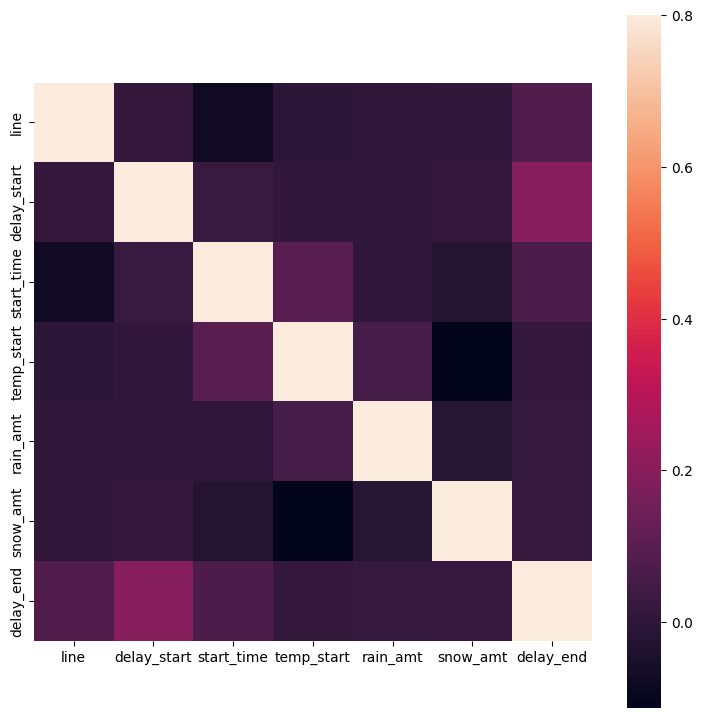

In [3]:
Corr_mat = df_test.corr()
fig = plt.figure(figsize = (9,9))

sb.heatmap(Corr_mat, vmax = .8, square = True)
plt.show()

In [4]:
predictors = ['delay_start', 'start_time', 'temp_start', 'rain_amt', 'snow_amt', 'line']
outcome = 'delay_end'

In [5]:
for i in range(len(predictors)):
    for j in range(len(predictors)):
        if i<j:
            corr, _ = pearsonr(df_test[predictors[i]], df_test[predictors[j]])
            print('The correlation between', predictors[i], 'and', predictors[j], 'is', corr)

The correlation between delay_start and start_time is 0.02443191113084113
The correlation between delay_start and temp_start is 0.005926468145248256
The correlation between delay_start and rain_amt is 0.00391874668369688
The correlation between delay_start and snow_amt is 0.008249960576945126
The correlation between delay_start and line is 0.011574383589575663
The correlation between start_time and temp_start is 0.10077189984427724
The correlation between start_time and rain_amt is 0.00425334001924677
The correlation between start_time and snow_amt is -0.024176273843384725
The correlation between start_time and line is -0.07727617810622817
The correlation between temp_start and rain_amt is 0.05680562338511451
The correlation between temp_start and snow_amt is -0.11309762999522527
The correlation between temp_start and line is -0.0042074495148836325
The correlation between rain_amt and snow_amt is -0.018916201405556533
The correlation between rain_amt and line is 0.00406770491632639
The

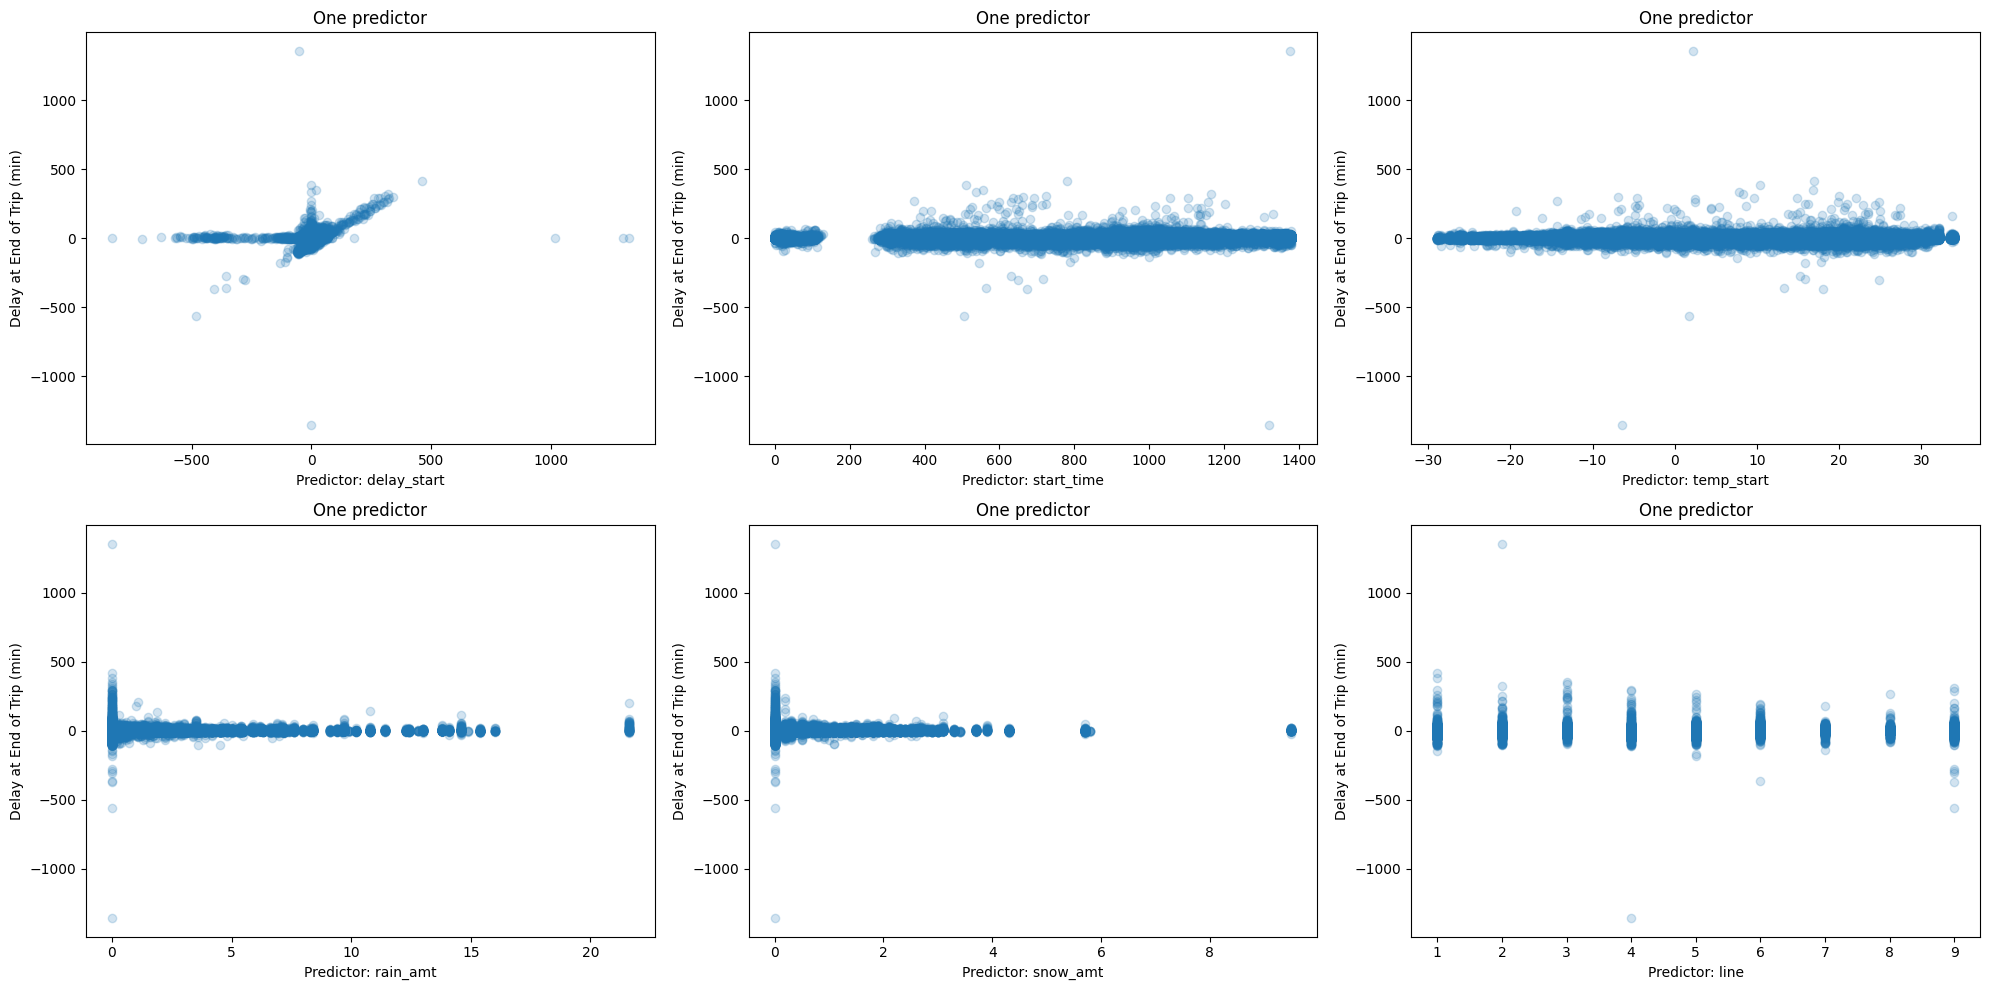

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, axi in enumerate(ax.flat):
    axi.scatter(df_test[predictors[i]], df_test[outcome], color='tab:blue', alpha=0.2)
    axi.set_ylabel('Delay at End of Trip (min)')
    axi.set_xlabel(f'Predictor: {predictors[i]}')
    axi.set_title("One predictor");

plt.tight_layout()
plt.show()

In [7]:
model = sm.OLS(df_test[outcome], df_test[predictors].assign(const=1))
results = model.fit()

In [8]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              delay_end   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     5998.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:18:15   Log-Likelihood:            -2.4334e+06
No. Observations:              697550   AIC:                         4.867e+06
Df Residuals:                  697543   BIC:                         4.867e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
delay_start     0.2073      0.001    163.832      0.000       0.205       0.210
start_time      0.0018      3e-05     60.341      0.000       0.002       0.002
temp_start      0.0048      0.001      5.971      0.000       0.003       0.006
rain_amt        0.2018      0.014     14.107      0.000       0.174       0.230
snow_amt        0.8121      0.043     19.077      0.000       0.729       0.896
line            0.2835      0.004     67.653      0.000       0.275       0.292
const          -0.2914      0.031     -9.280      0.000      -0.353      -0.230
==============================================================================
Omnibus:                   537217.729   Durbin-Watson:                   1.555
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     195004436719.336
Skew:                           1.488   Prob(JB):                         0.00
Kurtosis:                    2593.239   Cond. No.                     3.78e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
mse = results.mse_resid

In [10]:
mse**0.5

7.921241181097022

In [11]:
results.params

delay_start    0.207299
start_time     0.001813
temp_start     0.004778
rain_amt       0.201840
snow_amt       0.812094
line           0.283506
const         -0.291413
dtype: float64

In [12]:
para = results.params
delay = 2
time = 7*60 + 30
temp = 15
rain = 0.1
snow = 0
line = 1

X = [delay, time, temp, rain, snow,line,1]
prediction = np.dot(para, X)
print(f"The bus should be delayed by {prediction} minutes.")


The bus should be delayed by 1.3144960834516608 minutes.


We have a very unreliable model with R-squared 0.049\
The data is too noisy to find any linearity\
We will try to find clusters of data that might be helpful in finding a relationship between the variables

In [30]:
#find the delays over 90% of the mean delay
# first we find the mean delay
mean_delay = df_master['delay_end'].mean()
cutoff = mean_delay*0.9
print(cutoff)


2.168390366281987


In [31]:
df_m = df_master.copy()

In [32]:
#create a new column for time of day in minutes (tod_end) and another one for the hour of the day (hour_end)
df_m['tod_end'] = pd.to_datetime(df_m['end_time'], format='%H:%M:%S')
df_m['tod_end'] = df_m['tod_end'].dt.hour * 60 + df_m['tod_end'].dt.minute
df_m['hour_end'] = pd.to_datetime(df_m['end_time'], format='%H:%M:%S')
df_m['hour_end'] = df_m['hour_end'].dt.hour

#convert the start_time column to minutes after midnight
df_m['start_time'] = pd.to_datetime(df_m['start_time'], format='%H:%M:%S')
df_m['start_time'] = df_m['start_time'].dt.hour * 60 + df_m['start_time'].dt.minute

df_m.head()

,line,delay_start,start_time,end_time,temp_start,rain_amt,snow_amt,delay_end,tod_end,hour_end
0,3.0,0,10,00:44:00,15.1,0.0,0.0,-1,44,0
1,3.0,0,42,01:14:00,15.1,0.0,0.0,-3,74,1
2,3.0,-1,73,01:44:00,13.7,0.0,0.0,-5,104,1
3,3.0,0,306,05:39:00,11.8,0.0,0.0,-2,339,5
4,3.0,2,341,06:13:00,11.8,0.0,0.0,-1,373,6


In [33]:
#take data as delay as a function of end time (sort by end time)
#scan the data for any delays over the cutoff
#if there is a delay over the cutoff, check the next datapoint to see if it is also over the cutoff
#if it is, add the delay to a new dataframe

#create a dictionary of dataframes for each line AND hour of the day
df_line_hour = {value: df_m.loc[df_m['hour_end'] == value] for value in df_m['hour_end'].unique()}
df_line_hour = {key: {value: df_line_hour[key].loc[df_line_hour[key]['line'] == value] for value in df_line_hour[key]['line'].unique()} for key in df_line_hour.keys()}
#each dataframe can be accessed by df_line_hour[hour][line], e.g. df_line_hour[7][1] is the dataframe for line 1 at 7am

# Create dictionary df_lhtop10 to store the dataframes with delays over 90% of the mean delay
df_lhtop10 = {key: {} for key in df_line_hour.keys()}

for key in df_line_hour.keys():
    for value in df_line_hour[key].keys():
        # Sort df_line_hour[hour][line] by the values of 'tod_end'
        df_line_hour[key][value] = df_line_hour[key][value].sort_values(by='tod_end')
        # Create a boolean mask for rows where 'delay_end' is greater than or equal to the cutoff
        mask = df_line_hour[key][value]['delay_end'] >= cutoff
        # Shift the mask by one to compare with the next row
        mask_shifted = mask.shift(-1)
        # Combine the masks and select the rows from df_line_hour[hour][line]
        df_lhtop10[key][value] = df_line_hour[key][value][mask & mask_shifted].copy()

#each dataframe in df_lhtop10 can be accessed by df_lhtop10[hour][line], e.g. df_lhtop10[7][1] is the dataframe for line 1 at 7am



# Remove dataframes with less than 10 rows
for key in df_lhtop10.keys():
    for value in list(df_lhtop10[key].keys()):  # Create a list of keys since we're modifying the dictionary
        if len(df_lhtop10[key][value]) < 10:
            df_lhtop10[key].pop(value, None)

# print a list of all the keys (meaning dataframes with delays over 90% of the mean delay)
for key in df_lhtop10.keys():
    for value in df_lhtop10[key].keys():
        print(key, value)

#print the amount of dataframes in df_lhtop10
total_dfs = sum(len(df_lhtop10[hour]) for hour in df_lhtop10.keys())
print(total_dfs)

0 3.0
0 4.0
0 1.0
0 2.0
0 5.0
0 6.0
1 3.0
1 4.0
1 1.0
1 2.0
1 5.0
1 6.0
5 3.0
5 4.0
5 5.0
5 1.0
5 2.0
5 6.0
6 3.0
6 4.0
6 5.0
6 6.0
6 9.0
6 7.0
6 1.0
6 2.0
7 3.0
7 4.0
7 5.0
7 6.0
7 9.0
7 7.0
7 8.0
7 1.0
7 2.0
8 3.0
8 4.0
8 5.0
8 6.0
8 9.0
8 7.0
8 8.0
8 1.0
8 2.0
9 3.0
9 4.0
9 5.0
9 6.0
9 9.0
9 7.0
9 8.0
9 1.0
9 2.0
10 3.0
10 4.0
10 5.0
10 9.0
10 7.0
10 8.0
10 1.0
10 2.0
10 6.0
11 3.0
11 4.0
11 5.0
11 7.0
11 1.0
11 2.0
11 6.0
12 3.0
12 4.0
12 5.0
12 7.0
12 1.0
12 2.0
12 6.0
13 3.0
13 4.0
13 5.0
13 7.0
13 1.0
13 2.0
13 6.0
14 3.0
14 4.0
14 5.0
14 7.0
14 1.0
14 2.0
14 6.0
15 3.0
15 4.0
15 5.0
15 6.0
15 7.0
15 1.0
15 2.0
15 9.0
16 3.0
16 4.0
16 5.0
16 6.0
16 9.0
16 7.0
16 8.0
16 1.0
16 2.0
17 3.0
17 4.0
17 5.0
17 6.0
17 9.0
17 7.0
17 8.0
17 1.0
17 2.0
18 3.0
18 4.0
18 5.0
18 6.0
18 9.0
18 7.0
18 8.0
18 1.0
18 2.0
19 3.0
19 4.0
19 5.0
19 6.0
19 9.0
19 7.0
19 8.0
19 1.0
19 2.0
20 3.0
20 4.0
20 5.0
20 9.0
20 8.0
20 1.0
20 2.0
20 6.0
21 3.0
21 4.0
21 5.0
21 1.0
21 2.0
21 6.0
22 3.0
22 4.0
22 

In [34]:
total_dfs = sum(len(df_lhtop10[hour]) for hour in df_lhtop10.keys())
print(total_dfs)

165


In [35]:
total_dfs = sum(len(df_lhtop10[hour]) for hour in df_lhtop10.keys())
print(total_dfs)

165


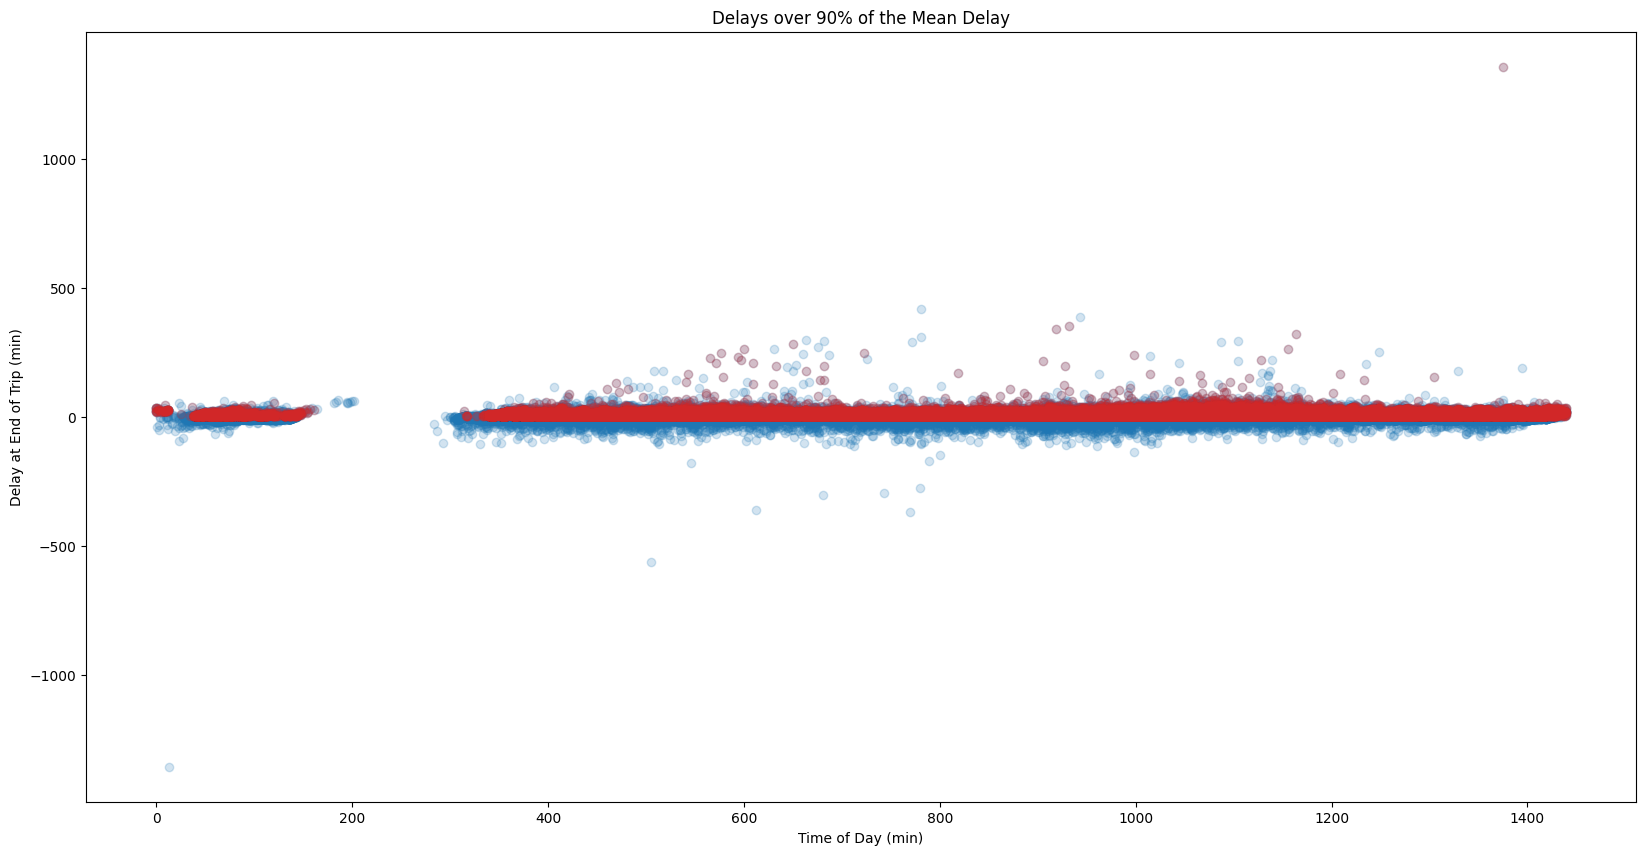

In [36]:
# Create a new dataframe with all the dataframes in df_lhtop10
df_top10 = pd.concat([df_lhtop10[key][value] for key in df_lhtop10.keys() for value in df_lhtop10[key].keys()])
df_top10 = df_top10.sort_values(by='tod_end')
df_top10.head()

#visualize the data by plotting df_m and df_top10  with delay_end on the y axis and tod_end on the x axis
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(df_m['tod_end'], df_m['delay_end'], color='tab:blue', alpha=0.2)
ax.scatter(df_top10['tod_end'], df_top10['delay_end'], color='tab:red', alpha=0.2)
ax.set_ylabel('Delay at End of Trip (min)')
ax.set_xlabel('Time of Day (min)')
ax.set_title('Delays over 90% of the Mean Delay')
plt.show()


In [37]:
#create a model with each dataframe in df_lhtop10 and return the r-squared value

# Create a dictionary to store the r-squared values
rsquared = {key: {} for key in df_lhtop10.keys()}

for key in df_lhtop10.keys():
    for value in df_lhtop10[key].keys():
        # Create a model for each dataframe in df_lhtop10
        model = sm.OLS(df_lhtop10[key][value]['delay_end'], df_lhtop10[key][value][predictors])
        results = model.fit()
        # Store the r-squared value in rsquared
        rsquared[key][value] = results.rsquared

# Print the r-squared values
for key in rsquared.keys():
    for value in rsquared[key].keys():
        print(key, value, rsquared[key][value])



0 3.0 0.3470785167983429
0 4.0 0.9361465852505668
0 1.0 0.9287340051636533
0 2.0 0.4123430912902941
0 5.0 0.47974263186422805
0 6.0 0.3975283280583909
1 3.0 0.5866019957151203
1 4.0 0.3084744689266097
1 1.0 0.09652587984609806
1 2.0 0.4244502461840387
1 5.0 0.08555330725338017
1 6.0 0.1984034527040126
5 3.0 0.7729909023874854
5 4.0 0.10124582647756564
5 5.0 0.14080162307574062
5 1.0 0.35627757317464737
5 2.0 0.0027789751403491936
5 6.0 0.029225597977548867
6 3.0 0.15529325506042302
6 4.0 0.14050081465736042
6 5.0 0.1958205798215673
6 6.0 0.31842014137541175
6 9.0 0.21346800136694555
6 7.0 0.07301620787977636
6 1.0 0.42346017403183744
6 2.0 0.12191174233271462
7 3.0 0.25657320572118936
7 4.0 0.3948158143079379
7 5.0 0.19002659079485462
7 6.0 0.055615412418048016
7 9.0 0.09372863376473262
7 7.0 0.03379263329677018
7 8.0 0.18286096315359646
7 1.0 0.3238974956367241
7 2.0 0.2510644184836369
8 3.0 0.07048794277577286
8 4.0 0.04303498414592133
8 5.0 0.09041660600179546
8 6.0 0.12171479775264

In [38]:
# remove end_time, tod_end and hour_end from all dataframes in df_lhtop10

for key in df_lhtop10.keys():
    for value in df_lhtop10[key].keys():
        df_lhtop10[key][value] = df_lhtop10[key][value].drop(columns=['end_time', 'tod_end', 'hour_end'])


In [39]:
# merge all dataframes in df_lhtop10 into one dataframe
df_final = pd.concat([df_lhtop10[key][value] for key in df_lhtop10.keys() for value in df_lhtop10[key].keys()])
df_final = df_final.sort_values(by='start_time')
df_final.head()


,line,delay_start,start_time,temp_start,rain_amt,snow_amt,delay_end
295583,2.0,0,0,15.3,0.0,0.0,7
492136,2.0,0,0,-6.2,0.0,0.0,5
112898,5.0,2,0,-21.7,0.0,0.0,10
225462,5.0,3,0,13.6,0.0,0.0,11
37734,2.0,0,0,8.4,0.0,0.0,5


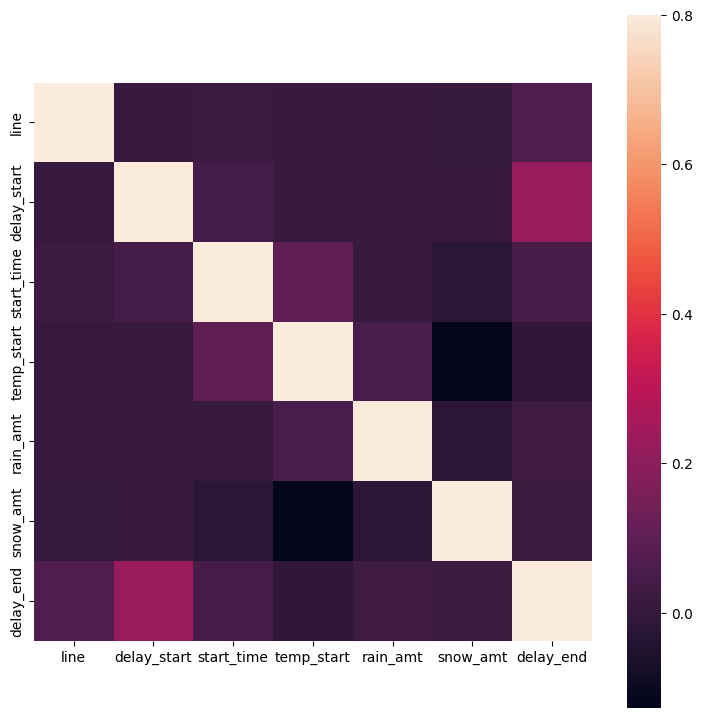

In [40]:
Corr_mat = df_final.corr()
fig = plt.figure(figsize = (9,9))

sb.heatmap(Corr_mat, vmax = .8, square = True)
plt.show()

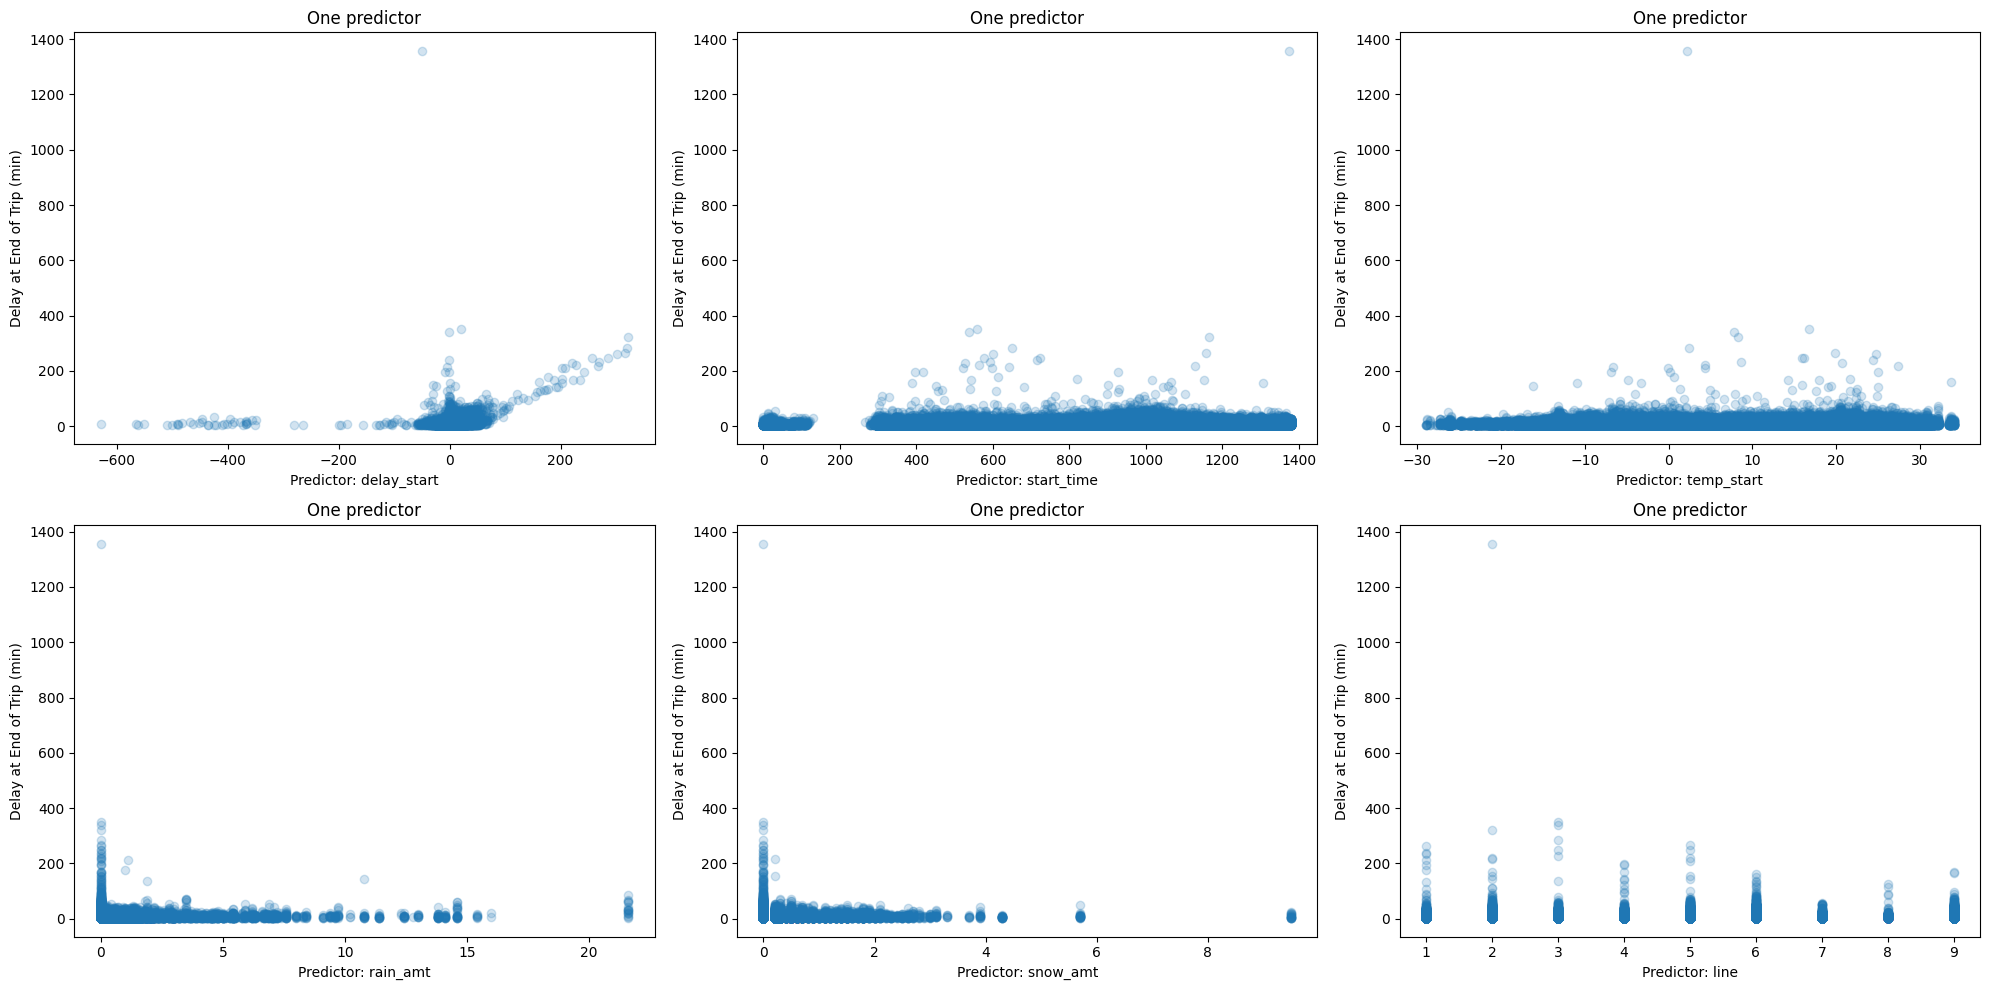

In [41]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, axi in enumerate(ax.flat):
    axi.scatter(df_final[predictors[i]], df_final[outcome], color='tab:blue', alpha=0.2)
    axi.set_ylabel('Delay at End of Trip (min)')
    axi.set_xlabel(f'Predictor: {predictors[i]}')
    axi.set_title("One predictor");

plt.tight_layout()
plt.show()

In [42]:
model = sm.OLS(df_final[outcome], df_final[predictors].assign(const=1))
results = model.fit()

In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              delay_end   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     1701.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:21:56   Log-Likelihood:            -5.6907e+05
No. Observations:              167749   AIC:                         1.138e+06
Df Residuals:                  167742   BIC:                         1.138e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
delay_start     0.1915      0.002     93.495      0.000       0.188       0.196
start_time      0.0011   6.19e-05     17.385      0.000       0.001       0.001
temp_start     -0.0099      0.001     -6.687      0.000      -0.013      -0.007
rain_amt        0.2923      0.026     11.114      0.000       0.241       0.344
snow_amt        0.4995      0.074      6.712      0.000       0.354       0.645
line            0.2221      0.008     27.292      0.000       0.206       0.238
const           6.7251      0.063    106.519      0.000       6.601       6.849
==============================================================================
Omnibus:                   513660.563   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     413443257014.342
Skew:                          45.421   Prob(JB):                         0.00
Kurtosis:                    7693.478   Cond. No.                     3.65e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
model4 = sm.OLS(df_final['delay_end'], df_final['delay_start'])
results = model4.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              delay_end   R-squared (uncentered):                   0.051
Model:                            OLS   Adj. R-squared (uncentered):              0.051
Method:                 Least Squares   F-statistic:                              9008.
Date:                Fri, 17 Nov 2023   Prob (F-statistic):                        0.00
Time:                        14:21:56   Log-Likelihood:                     -6.4198e+05
No. Observations:              167749   AIC:                                  1.284e+06
Df Residuals:                  167748   BIC:                                  1.284e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
delay_start     0.2983      0.003     94.911      0.000       0.292       0.304
==============================================================================
Omnibus:                   510772.554   Durbin-Watson:                   0.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     389810494545.510
Skew:                          44.708   Prob(JB):                         0.00
Kurtosis:                    7470.432   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
model5 = sm.OLS(df_master['delay_end'], df_master['delay_start'])
results = model5.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              delay_end   R-squared (uncentered):                   0.041
Model:                            OLS   Adj. R-squared (uncentered):              0.041
Method:                 Least Squares   F-statistic:                          2.987e+04
Date:                Fri, 17 Nov 2023   Prob (F-statistic):                        0.00
Time:                        14:21:56   Log-Likelihood:                     -2.4657e+06
No. Observations:              697550   AIC:                                  4.931e+06
Df Residuals:                  697549   BIC:                                  4.931e+06
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
delay_start     0.2285      0.001    172.819      0.000       0.226       0.231
==============================================================================
Omnibus:                   543650.395   Durbin-Watson:                   1.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     185910812640.508
Skew:                           1.545   Prob(JB):                         0.00
Kurtosis:                    2532.123   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""